Imports aus der Vorlesung genommen (nicht sicher ob wir alles brauchen)

In [967]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Daten laden

In [968]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


In [969]:
data = load_csv_data('csv_chris')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear_Acceleration_Jump', 'Linear_Acceleration_Squat'])


In [970]:
print("Jump Accelerometer Data:")
print(jump_acc.describe())


Jump Accelerometer Data:
          Time (s)  Linear Acceleration x (m/s^2)  \
count  1000.000000                    1000.000000   
mean      5.029218                      -0.141517   
std       2.893032                       1.463748   
min       0.025841                      -6.183743   
25%       2.527548                      -0.867886   
50%       5.029269                       0.044400   
75%       7.530910                       0.714505   
max      10.032591                       6.726061   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                    1000.000000                    1000.000000  
mean                       -0.942980                       0.712514  
std                         7.916903                       8.130801  
min                       -13.514476                     -13.931807  
25%                        -8.002588                      -5.227082  
50%                        -0.972241                      -1.085678  
75%    

In [971]:
print("Jump Gyroscope Data:")
print(jump_gyr.describe())


Jump Gyroscope Data:
          Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  1002.000000          1002.000000          1002.000000   
mean      5.029218            -0.024954             0.003046   
std       2.898816             1.500065             0.508044   
min       0.015840            -5.316045            -2.130067   
25%       2.522539            -0.736742            -0.233685   
50%       5.029269            -0.014247             0.045672   
75%       7.535917             0.817167             0.298665   
max      10.042602             4.082772             1.524748   

       Gyroscope z (rad/s)  
count          1002.000000  
mean             -0.013484  
std               0.318341  
min              -1.195325  
25%              -0.183353  
50%              -0.012383  
75%               0.154326  
max               1.084274  


In [972]:
print("Squat Accelerometer Data:")
print(squat_acc.describe())

Squat Accelerometer Data:
         Time (s)  Linear Acceleration x (m/s^2)  \
count  998.000000                     998.000000   
mean     5.072227                      -0.032296   
std      2.887386                       1.036910   
min      0.078621                      -5.508262   
25%      2.575498                      -0.355834   
50%      5.072192                       0.032742   
75%      7.568906                       0.489639   
max     10.065848                       3.775778   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                     998.000000                     998.000000  
mean                       -0.157762                       0.306951  
std                         5.661265                       3.980603  
min                        -6.620842                      -6.482760  
25%                        -4.353138                      -2.539083  
50%                        -1.966947                      -0.569178  
75%            

In [973]:
print("Squat Gyroscope Data:")
print(squat_gyr.describe())

Squat Gyroscope Data:
          Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  1002.000000          1002.000000          1002.000000   
mean      5.062210             0.012565             0.011520   
std       2.898953             0.554644             0.373755   
min       0.048614            -1.537131            -1.360569   
25%       2.555465            -0.339277            -0.173500   
50%       5.062169             0.010120            -0.011318   
75%       7.568906             0.385614             0.171369   
max      10.075859             1.830070             1.819285   

       Gyroscope z (rad/s)  
count          1002.000000  
mean              0.006767  
std               0.251389  
min              -0.760443  
25%              -0.154059  
50%              -0.011584  
75%               0.138613  
max               0.983343  


In [974]:
def trim_dataframes_to_shortest(df_list):
    # Bestimmen der minimalen Länge aller DataFrames in der Liste
    min_length = min(df.shape[0] for df in df_list)

    # Kürzen aller DataFrames auf die minimale Länge
    trimmed_dfs = [df.iloc[:min_length] for df in df_list]

    return trimmed_dfs

In [975]:
jump_acc, jump_gyr, squat_acc, squat_gyr = trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

In [976]:
jump_acc.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
count,998.000000,998.000000,998.000000,998.000000
mean,5.019201,-0.136915,-0.957055,0.677006
std,2.887249,1.461482,7.918580,8.099980
min,0.025841,-6.183743,-13.514476,-13.931807
25%,2.522539,-0.857719,-8.015454,-5.234509
50%,5.019252,0.046873,-0.994256,-1.104369
75%,7.515883,0.715230,5.194098,5.404385
max,10.012572,6.726061,20.305126,30.428843


In [977]:
jump_gyr.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,998.000000,998.000000,998.000000,998.000000
mean,5.009184,-0.014781,0.002681,-0.012250
std,2.887249,1.492876,0.507831,0.318165
min,0.015840,-5.316045,-2.130067,-1.195325
25%,2.512522,-0.723693,-0.233685,-0.179891
50%,5.009236,-0.012650,0.045672,-0.010785
75%,7.505866,0.820096,0.298665,0.154326
max,10.002547,4.082772,1.524748,1.084274


Funktion zum Plotten

In [978]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [979]:
compare_acc_gyr(jump_acc,jump_gyr)

In [980]:
compare_acc_gyr(squat_acc,squat_gyr)

### Relevante Spalten extrahieren

In [981]:
print(jump_acc.describe())

         Time (s)  Linear Acceleration x (m/s^2)  \
count  998.000000                     998.000000   
mean     5.019201                      -0.136915   
std      2.887249                       1.461482   
min      0.025841                      -6.183743   
25%      2.522539                      -0.857719   
50%      5.019252                       0.046873   
75%      7.515883                       0.715230   
max     10.012572                       6.726061   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                     998.000000                     998.000000  
mean                       -0.957055                       0.677006  
std                         7.918580                       8.099980  
min                       -13.514476                     -13.931807  
25%                        -8.015454                      -5.234509  
50%                        -0.994256                      -1.104369  
75%                         5.194098     

In [982]:
print(jump_gyr.describe())

         Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  998.000000           998.000000           998.000000   
mean     5.009184            -0.014781             0.002681   
std      2.887249             1.492876             0.507831   
min      0.015840            -5.316045            -2.130067   
25%      2.512522            -0.723693            -0.233685   
50%      5.009236            -0.012650             0.045672   
75%      7.505866             0.820096             0.298665   
max     10.002547             4.082772             1.524748   

       Gyroscope z (rad/s)  
count           998.000000  
mean             -0.012250  
std               0.318165  
min              -1.195325  
25%              -0.179891  
50%              -0.010785  
75%               0.154326  
max               1.084274  


In [983]:
def combine_relevant_columns(acc_df, gyr_df):
    linear_acc_z = acc_df['Linear Acceleration z (m/s^2)']
    linear_acc_y = acc_df['Linear Acceleration y (m/s^2)']

    gyroskop_x = gyr_df['Gyroscope x (rad/s)']

    time = gyr_df['Time (s)']

    return pd.DataFrame({
        'Time (s)': time,
        'Linear Acceleration z (m/s^2)': linear_acc_z,
        'Linear Acceleration y (m/s^2)': linear_acc_y,
        'Gyroscope x (rad/s)': gyroskop_x
    })

In [984]:
combined_df = combine_relevant_columns(jump_acc, jump_gyr)
print(combined_df.head())
print(combined_df.describe())

   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.015840                       0.000000                       0.000000   
1  0.025841                       0.297343                      -0.000207   
2  0.035844                       0.521891                       0.064322   
3  0.045852                       0.728961                       0.227171   
4  0.055862                       0.789543                       0.372744   

   Gyroscope x (rad/s)  
0            -0.539407  
1            -0.619300  
2            -0.649126  
3            -0.637409  
4            -0.589473  
         Time (s)  Linear Acceleration z (m/s^2)  \
count  998.000000                     998.000000   
mean     5.009184                       0.677006   
std      2.887249                       8.099980   
min      0.015840                     -13.931807   
25%      2.512522                      -5.234509   
50%      5.009236                      -1.104369   
75%      7.505866      

In [985]:
print(combined_df.describe())


         Time (s)  Linear Acceleration z (m/s^2)  \
count  998.000000                     998.000000   
mean     5.009184                       0.677006   
std      2.887249                       8.099980   
min      0.015840                     -13.931807   
25%      2.512522                      -5.234509   
50%      5.009236                      -1.104369   
75%      7.505866                       5.404385   
max     10.002547                      30.428843   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                     998.000000           998.000000  
mean                       -0.957055            -0.014781  
std                         7.918580             1.492876  
min                       -13.514476            -5.316045  
25%                        -8.015454            -0.723693  
50%                        -0.994256            -0.012650  
75%                         5.194098             0.820096  
max                        20.305126             4.

In [986]:
jump_df = combine_relevant_columns(jump_acc, jump_gyr)

In [987]:
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

In [988]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])
    num_columns = len(filtered_df.columns)

    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        # Normalisierung der Amplituden
        max_amplitude = np.max(amplitudes)
        normalized_amplitudes = amplitudes / max_amplitude

        # Filtern für positive Frequenzen
        positive_indices = np.where(frequencies > 0)
        positive_frequencies = frequencies[positive_indices]
        positive_normalized_amplitudes = normalized_amplitudes[positive_indices]

        # Erstellen der Subplots
        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_normalized_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Normalized Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

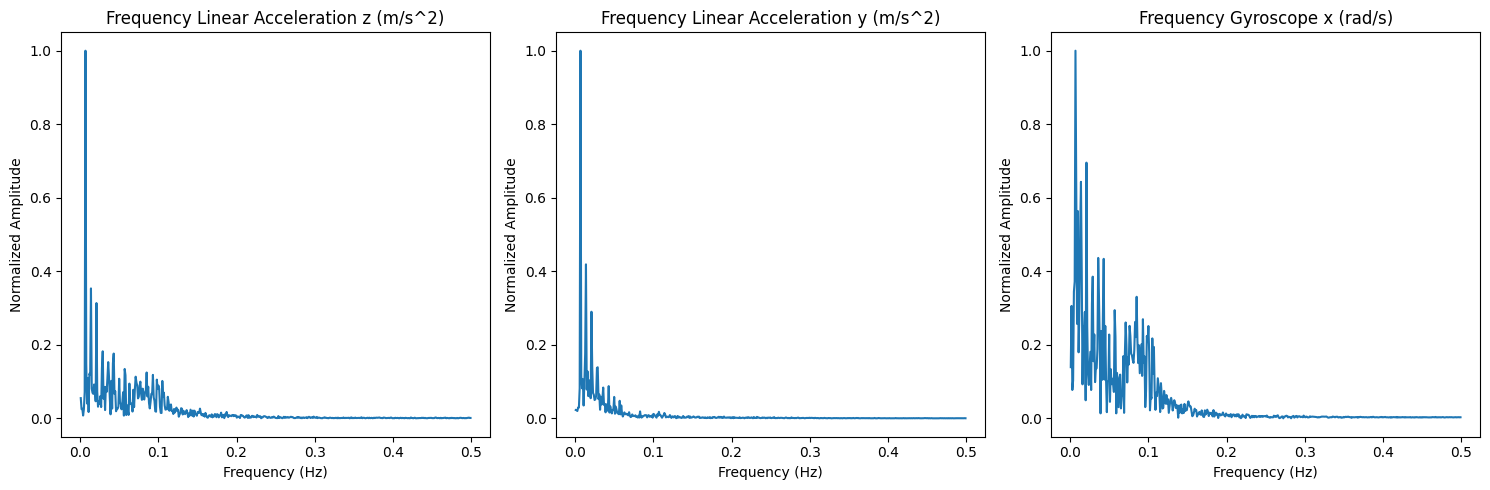

In [989]:
plot_frequencies(squat_df)

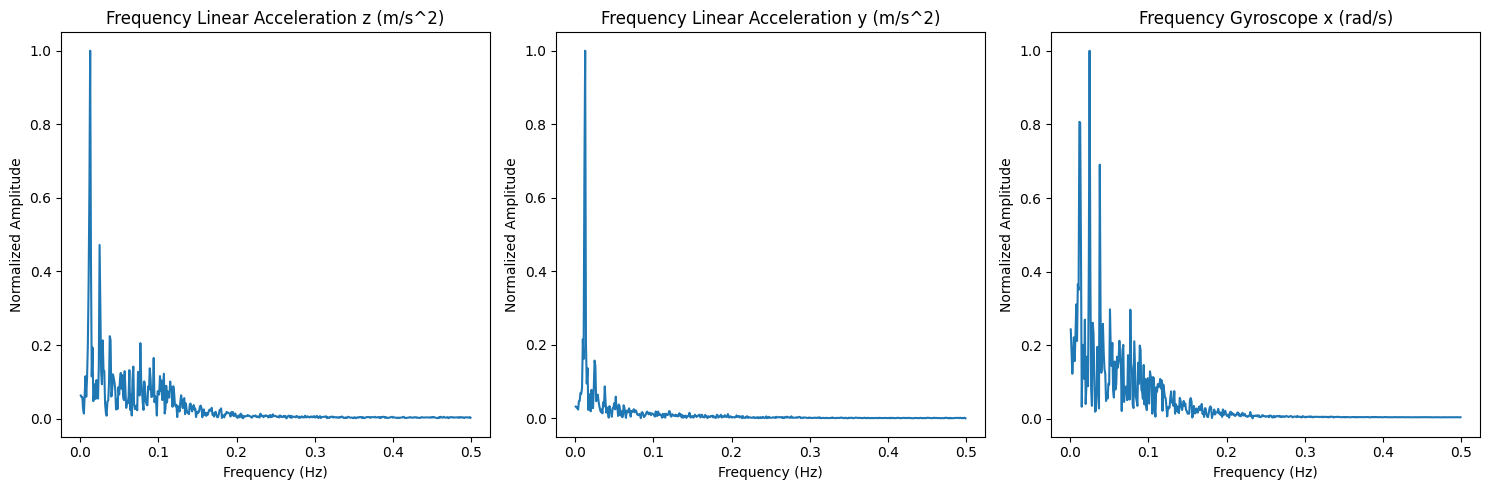

In [990]:
plot_frequencies(jump_df)

### Filtern der Frequenzen

In [991]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 5
    low_cutoff = 5

    # Butterworth Tiefpass erstellen
    b, a = butter(filter_order, low_cutoff, btype='low', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe

In [992]:
filtered_df_sq = filter_frequency(squat_df)

In [993]:
filtered_df_j = filter_frequency(jump_df)

In [994]:
def plot_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [995]:
def plot_normal_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Z'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Gyr_X'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

Frequenz gefiltert

In [996]:
plot_df(filtered_df_j)

In [997]:
plot_df(filtered_df_sq)

In [998]:
filtered_df_j_z = filtered_df_j.copy()
# # Korrekte Spaltennamen verwenden
# filtered_df_j_z['Z_Score_Y'] = stats.zscore(filtered_df_j['Linear Acceleration y (m/s^2)'])
# filtered_df_j_z['Z_Score_Z'] = stats.zscore(filtered_df_j['Linear Acceleration z (m/s^2)'])
# filtered_df_j_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_j['Gyroscope x (rad/s)']) 
# print(filtered_df_j_z.head())

# # Schwellenwert definieren
# z_score_threshold = 3

# # Ausreißer filtern
# filtered_df_j_z = filtered_df_j_z[(abs(filtered_df_j_z['Z_Score_Gyr_X']) <= z_score_threshold) &
#                                   (abs(filtered_df_j_z['Z_Score_Y']) <= z_score_threshold) &
#                                   (abs(filtered_df_j_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.015840                      -0.008966                      -0.003578   
1  0.025841                       0.032910                       0.066689   
2  0.035844                       0.073442                       0.134383   
3  0.045852                       0.110992                       0.197260   
4  0.055862                       0.144419                       0.253466   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0            -0.536078   0.121897  -0.094203      -0.392963  
1            -0.518428   0.130855  -0.088490      -0.379643  
2            -0.501248   0.139485  -0.082961      -0.366678  
3            -0.484660   0.147502  -0.077839      -0.354159  
4            -0.468778   0.154667  -0.073279      -0.342173  


In [999]:
filtered_df_sq_z = filtered_df_sq.copy()
# # Korrekte Spaltennamen verwenden
# filtered_df_sq_z['Z_Score_Y'] = stats.zscore(filtered_df_sq['Linear Acceleration y (m/s^2)'])
# filtered_df_sq_z['Z_Score_Z'] = stats.zscore(filtered_df_sq['Linear Acceleration z (m/s^2)'])
# filtered_df_sq_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_sq['Gyroscope x (rad/s)']) 
# print(filtered_df_sq_z.head())

# # Schwellenwert definieren
# z_score_threshold = 3

# # Ausreißer filtern
# filtered_df_sq_z = filtered_df_sq_z[(abs(filtered_df_sq_z['Z_Score_Gyr_X']) <= z_score_threshold) &
#                                   (abs(filtered_df_sq_z['Z_Score_Y']) <= z_score_threshold) &
#                                   (abs(filtered_df_sq_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.048614                      -0.014859                      -0.006101   
1  0.058615                       0.001399                      -0.017992   
2  0.068617                       0.018736                      -0.033902   
3  0.078621                       0.037071                      -0.058115   
4  0.088627                       0.056027                      -0.094407   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0            -0.025790   0.027182  -0.089602      -0.088887  
1            -0.056342   0.025067  -0.085093      -0.153737  
2            -0.086949   0.022236  -0.080284      -0.218704  
3            -0.116529   0.017929  -0.075198      -0.281489  
4            -0.143950   0.011473  -0.069940      -0.339693  


Außreißer gefiltert

In [1000]:
plot_normal_df(filtered_df_sq_z)

In [1001]:
plot_normal_df(filtered_df_j_z)

In [1002]:
def plot_peaks(df, peaks):
    # Berechnung der Abstände zwischen aufeinanderfolgenden Peaks
    distances = np.diff(peaks)
    # Finden des größten Abstands
    max_distance_idx = np.argmax(distances)
    peak1 = peaks[max_distance_idx]
    peak2 = peaks[max_distance_idx + 1]

    # Erstellen des Plots
    fig = go.Figure()

    # Hinzufügen der Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], mode='lines', name='Accel Y'))

    # Hervorheben der Peaks
    fig.add_trace(go.Scatter(x=df['Time (s)'].iloc[peaks], y=df['Z_Score_Y'].iloc[peaks], mode='markers', marker=dict(size=10, color='red'), name='Peaks'))

    # Zeichnen der Linie für den größten Abstand
    fig.add_trace(go.Scatter(x=[df['Time (s)'].iloc[peak1], df['Time (s)'].iloc[peak2]], 
                             y=[df['Z_Score_Y'].iloc[peak1], df['Z_Score_Y'].iloc[peak2]], 
                             mode='lines', 
                             line=dict(color='blue', width=2, dash='dash'),
                             name='Größter Abstand'))

    # Aktualisiere Layout und Labels
    fig.update_layout(
        title='Accelerometer Daten mit Peaks und größtem Abstand',
        xaxis_title='Zeit (s)',
        yaxis_title='Z-Score Accel Y',
        legend_title='Legende',
        height=600, width=800
    )

    fig.show()


In [1003]:
sq_peaks, _ = find_peaks(filtered_df_sq_z['Z_Score_Y'], prominence=2, height=1)
j_peaks, _ = find_peaks(filtered_df_j_z['Z_Score_Y'], prominence=2,height=1)

In [1004]:
filtered_df_sq_z['Label'] = 'squat'
filtered_df_j_z['Label'] = 'jump'

In [1005]:
def create_windows_based_on_peaks(df, peaks):
    windows = []
    labels = []

    for i in range(len(peaks) - 1):
        # Berechnen der halben Fenstergröße als halber Abstand zum nächsten Peak
        half_window = int((peaks[i + 1] - peaks[i]) / 2)

        # Start- und Endindex des Fensters berechnen
        start_index = max(0, peaks[i] - half_window)
        end_index = min(len(df), peaks[i] + half_window)

        # Fenster erstellen
        window = df.iloc[start_index:end_index]
        windows.append(window)

        # Label des Peaks extrahieren
        labels.append(df.iloc[peaks[i]]['Label'])

    # Behandlung des letzten Peaks
    if len(peaks) > 1:
        last_peak = peaks[-1]
        half_window = int((last_peak - peaks[-2]) / 2)
        start_index = max(0, last_peak - half_window)
        end_index = min(len(df), last_peak + half_window)

        # Letztes Fenster hinzufügen
        window = df.iloc[start_index:end_index]
        windows.append(window)
        labels.append(df.iloc[last_peak]['Label'])
    elif len(peaks) == 1:
        # Falls nur ein Peak vorhanden ist, betrachten Sie das Fenster um diesen Peak
        half_window = 10  # Eine standardmäßige Fenstergröße
        start_index = max(0, peaks[0] - half_window)
        end_index = min(len(df), peaks[0] + half_window)

        window = df.iloc[start_index:end_index]
        windows.append(window)
        labels.append(df.iloc[peaks[0]]['Label'])

    # Erstellen eines DataFrame für Labels
    label_df = pd.DataFrame(labels, columns=['Label'])

    return windows, label_df


In [1006]:
sq_windows, sq_label_df = create_windows_based_on_peaks(filtered_df_sq_z, sq_peaks)

In [1007]:
j_windows,j_label_df = create_windows_based_on_peaks(filtered_df_j_z, j_peaks)

In [1008]:

def plot_windows_with_data(df, windows, peaks):
    # Erstellen des Plots
    fig, ax = plt.subplots(figsize=(12, 6))

    # Hinzufügen der Accelerometer-Daten
    ax.plot(df['Time (s)'], df['Z_Score_Y'], label='Accel Y', color='grey')

    # Hervorheben der Peaks
    ax.scatter(df['Time (s)'].iloc[peaks], df['Z_Score_Y'].iloc[peaks], color='red', label='Peaks')

    # Hervorheben der Fenster
    for window in windows:
        ax.plot(window['Time (s)'], window['Z_Score_Y'], linewidth=2)

    # Aktualisiere Layout und Labels
    ax.set_title('Accelerometer Daten mit Peaks und Fenstern')
    ax.set_xlabel('Zeit (s)')
    ax.set_ylabel('Z-Score Accel Y')
    ax.legend()

    plt.show()

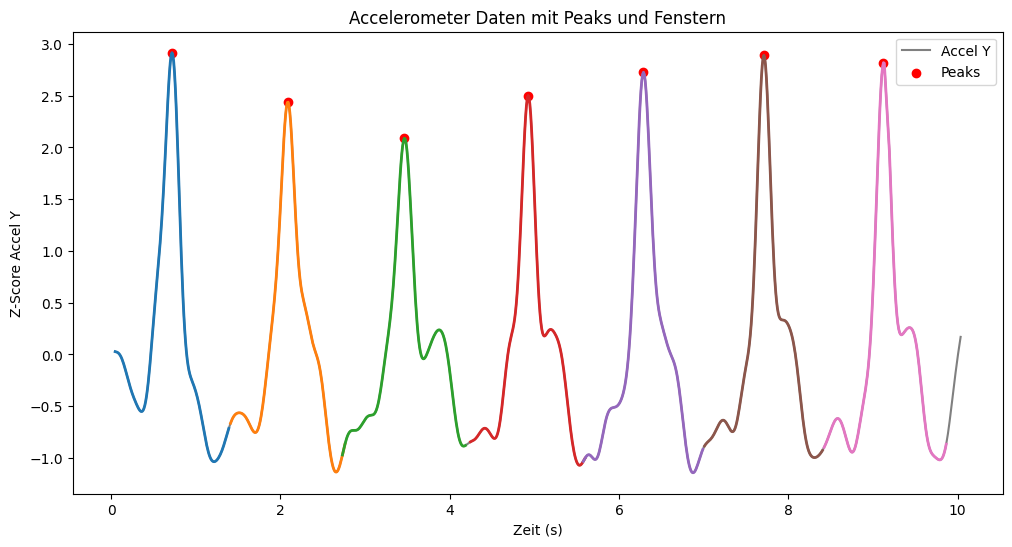

In [1009]:
plot_windows_with_data(filtered_df_sq_z, sq_windows, sq_peaks)

In [1018]:
print(filtered_df_sq_z.describe())

         Time (s)  Linear Acceleration z (m/s^2)  \
count  993.000000                     993.000000   
mean     5.021420                       0.250516   
std      2.879747                       3.523043   
min      0.048614                      -5.659303   
25%      2.532921                      -2.492098   
50%      5.017109                      -0.474303   
75%      7.501472                       1.732170   
max     10.035822                      11.030100   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)   Z_Score_Y  \
count                     993.000000           993.000000  993.000000   
mean                       -0.229784             0.016423   -0.012610   
std                         5.547860             0.471974    0.986942   
min                        -6.585672            -1.136645   -1.143297   
25%                        -4.345777            -0.325539   -0.744829   
50%                        -1.909378            -0.024953   -0.311403   
75%                 

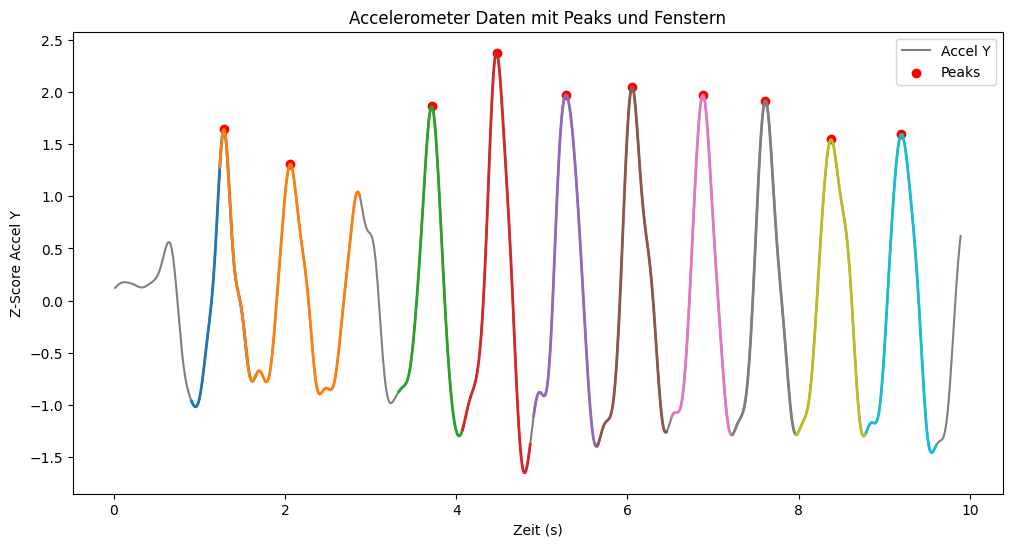

In [1010]:
plot_windows_with_data(filtered_df_j_z, j_windows, j_peaks)

In [1019]:
print(filtered_df_j_z.describe())

         Time (s)  Linear Acceleration z (m/s^2)  \
count  987.000000                     987.000000   
mean     4.954092                       0.542429   
std      2.855442                       7.240826   
min      0.015840                     -10.646592   
25%      2.484977                      -4.704988   
50%      4.954087                      -1.966773   
75%      7.423227                       5.019564   
max      9.892358                      21.329187   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)   Z_Score_Y  \
count                     987.000000           987.000000  987.000000   
mean                       -1.026164             0.034575   -0.008473   
std                         7.865783             1.244987    1.002812   
min                       -13.927011            -3.929890   -1.653207   
25%                        -7.970648            -0.577507   -0.893828   
50%                        -1.518276             0.020897   -0.071213   
75%                 

In [1011]:
def balance_windows_and_labels(smaller_windows, larger_windows, smaller_label_df, larger_label_df):
    factor = int(len(larger_windows) / len(smaller_windows))
    smaller_windows_balanced = smaller_windows * factor
    smaller_label_df_balanced = pd.concat([smaller_label_df] * factor, ignore_index=True)

    # Überprüfen, ob zusätzliche Fenster benötigt werden
    if factor == 1:
        difference = len(larger_windows) - len(smaller_windows_balanced)
        additional_windows = smaller_windows[:difference]
        additional_labels = smaller_label_df.iloc[:difference]

        smaller_windows_balanced += additional_windows
        smaller_label_df_balanced = pd.concat([smaller_label_df_balanced, additional_labels], ignore_index=True)

    return smaller_windows_balanced, smaller_label_df_balanced


In [1012]:
print(f"Anzahl der Fenster für jump: {len(j_windows)}")
print(f"Anzahl der Fenster für squat: {len(sq_windows)}")

if len(sq_windows) < len(j_windows):
    # Balance Jump Windows to match Squat Windows
    sq_windows, sq_label_df = balance_windows_and_labels(sq_windows, j_windows, sq_label_df, j_label_df)
else:
    # Balance Squat Windows to match Jump Windows
    j_windows, j_label_df = balance_windows_and_labels(j_windows, sq_windows, j_label_df, sq_label_df)

print(f"Anzahl der Fenster für jump: {len(j_windows)}")
print(f"Anzahl der Fenster für squat: {len(sq_windows)}")

label_df = pd.concat([sq_label_df, j_label_df], ignore_index=True)
windows = sq_windows + j_windows


Anzahl der Fenster für jump: 10
Anzahl der Fenster für squat: 7
Anzahl der Fenster für jump: 10
Anzahl der Fenster für squat: 10


In [1013]:
print(label_df.tail())

   Label
15  jump
16  jump
17  jump
18  jump
19  jump


In [1014]:
# Leere Liste erstellen, um Features zu speichern
feature_list = []

# Jeden DataFrame in windows einzeln durchgehen und für jede der drei Achsen die Features berechnen
for window in windows:
    acc_y = window['Z_Score_Y']
    acc_z = window['Z_Score_Z']
    gyro_x = window['Z_Score_Gyr_X']

    # Berechnete Werte an Liste anhängen, unter entsprechend benannten Spalten
    features = {
        'acc_y_peak': acc_y.max(),
        'acc_y_std_dev': acc_y.std(),
        'acc_y_variance': acc_y.var(),
        'acc_y_signal_energy': np.sum(acc_y**2),
        'acc_z_peak': acc_z.max(),
        'acc_z_std_dev': acc_z.std(),
        'acc_z_variance': acc_z.var(),
        'acc_z_signal_energy': np.sum(acc_z**2),
        'gyro_x_peak': gyro_x.max(),
        'gyro_x_std_dev': gyro_x.std(),
        'gyro_x_variance': gyro_x.var(),
        'gyro_x_signal_energy': np.sum(gyro_x**2)
    }
    feature_list.append(features)

feature_df = pd.DataFrame(feature_list)

print(feature_df.head())


   acc_y_peak  acc_y_std_dev  acc_y_variance  acc_y_signal_energy  acc_z_peak  \
0    2.915891       1.089536        1.187088           160.593851    2.437562   
1    2.438215       0.987845        0.975838           131.878232    2.311809   
2    2.089105       0.813749        0.662187            96.033298    2.390868   
3    2.500839       0.963284        0.927917           125.269782    2.858179   
4    2.727402       1.075567        1.156845           163.593052    2.820820   

   acc_z_std_dev  acc_z_variance  acc_z_signal_energy  gyro_x_peak  \
0       0.955396        0.912781           122.466272     1.905099   
1       0.954393        0.910865           122.967487     1.538750   
2       0.946229        0.895349           129.829530     2.740217   
3       1.130640        1.278346           172.978086     2.238093   
4       1.039658        1.080889           152.437297     2.010449   

   gyro_x_std_dev  gyro_x_variance  gyro_x_signal_energy  
0        0.833085         0.69403

Genauigkeit des Entscheidungsbaum-Classifiers: 0.5


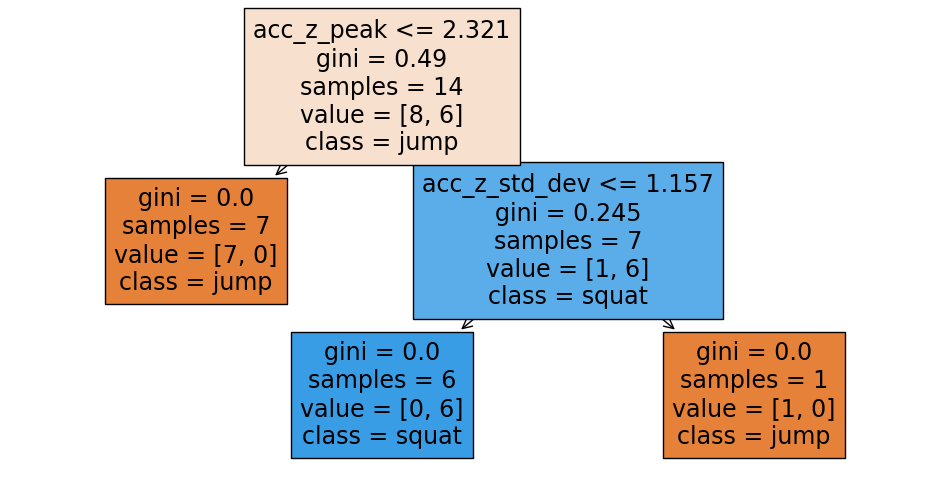

|--- acc_z_peak <= 2.32
|   |--- class: jump
|--- acc_z_peak >  2.32
|   |--- acc_z_std_dev <= 1.16
|   |   |--- class: squat
|   |--- acc_z_std_dev >  1.16
|   |   |--- class: jump



In [1015]:
from sklearn.metrics import classification_report, confusion_matrix

X = feature_df
y = label_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Modell testen
y_pred = clf.predict(X_test)

# Erstelle und trainiere den Entscheidungsbaum-Classifier
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

# Mache Vorhersagen auf dem Testset
y_pred = clf.predict(X_test)

# Berechne die Genauigkeit des Classifiers
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit des Entscheidungsbaum-Classifiers: {accuracy}")

# Visualisiere den Entscheidungsbaum
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_)
plt.show()

# Visualisiere den Entscheidungsbaum in Textform
tree_text = export_text(clf, feature_names=X.columns.tolist())
print(tree_text)






Clustering

In [1016]:
from sklearn.cluster import KMeans

# Anzahl der gewünschten Cluster festlegen 
anzahl_cluster = 2  # Passe dies an deine Anforderungen an.

# Initialisierung des K-Means-Cluster-Algorithmus
kmeans = KMeans(n_clusters=anzahl_cluster, random_state=0)

# Clustering auf den Daten in 'feature_df' durchführen
cluster_labels = kmeans.fit_predict(feature_df)

# Berechnete Cluster zu jedem der Datenpunkte im Feature Dataframe zuordnungen
feature_df['Cluster'] = cluster_labels

# Gib das aktualisierte DataFrame mit Clusterzuordnungen aus.
#print(feature_df.head())
feature_df.columns


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Index(['acc_y_peak', 'acc_y_std_dev', 'acc_y_variance', 'acc_y_signal_energy',
       'acc_z_peak', 'acc_z_std_dev', 'acc_z_variance', 'acc_z_signal_energy',
       'gyro_x_peak', 'gyro_x_std_dev', 'gyro_x_variance',
       'gyro_x_signal_energy', 'Cluster'],
      dtype='object')

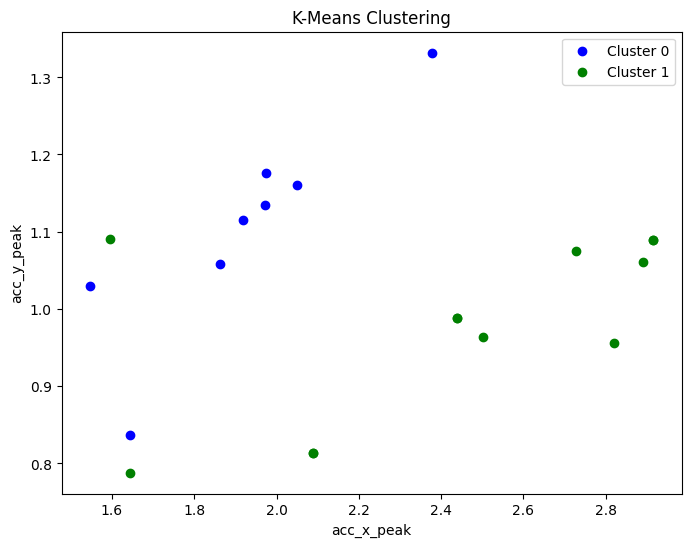

In [1017]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['acc_y_peak'], cluster_data['acc_y_std_dev'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('acc_x_peak')
plt.ylabel('acc_y_peak')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()
